<a id="sommaire"></a>
# Sommaire
* [Introduction](#Introduction)
    * Contexte et Objectifs
    * Questions de Recherche
* [Configuration de l'Environnement](#Configuration-de-lEnvironnement)
    * Importation des Bibliothèques
    * Chargement des Données
* [Exploration des Données](#Exploration-des-Données)
    * Aperçu des Données
    * Statistiques des Données
    * Vérification des Colonnes
* [Modélisation](#Modélisation)
    * Détermination du Nombre Optimal de Clusters
    * Application du Modèle de Clustering
* [Analyse et Visualisation des Clusters](#Analyse-et-Visualisation-des-Clusters)
    * Statistiques descriptives par Cluster
    * Visualisation des Variables pour Chaque Cluster
    * Évaluation de la Qualité du Clustering
    * Analyse des Moyennes des Caractéristiques par Cluster
* [Comparaison des Méthodes de Clustering](#Comparaison-des-Méthodes-de-Clustering)
    * Test du CAH
    * Test du DBSCAN


# Étape 1: Introduction <a class="anchor" id="Introduction"></a>

### Contexte du Projet de Segmentation Client pour Olist

Ce notebook constitue la deuxième phase de notre projet de segmentation des clients d'Olist. Après avoir effectué une analyse exploratoire des données et préparé les données pour la modélisation dans le premier notebook, nous nous engageons maintenant dans le cœur de notre mission : l'application de différentes approches de modélisation pour segmenter efficacement la clientèle d'Olist.

### Objectifs du Notebook

L'objectif de ce notebook est d'expérimenter avec diverses techniques de clustering pour identifier la méthode la plus adéquate pour segmenter les clients en fonction de leurs comportements d'achat et de leur satisfaction. Nous allons évaluer chaque modèle en fonction de sa performance et de sa pertinence pour le contexte commercial d'Olist.

[Retour au sommaire](#sommaire)

# Étape 2: Configuration de l'environnement <a class="anchor" id="Configuration-de-lEnvironnement"></a>

Nous débutons par l'importation des bibliothèques nécessaires pour l'analyse de clustering et la visualisation des données.

[Retour au sommaire](#sommaire)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import sys
import os
import warnings
warnings.filterwarnings("ignore")


# Étape 3 : Chargement et Première Exploration des Données <a class="anchor" id="Exploration-des-Données"></a>

Maintenant que notre environnement est configuré, nous pouvons charger les données transformées à partir du premier notebook et les examiner brièvement pour s'assurer de leur intégrité.

[Retour au sommaire](#sommaire)

**Configuration du chemin d'accès aux données**

In [2]:
path = 'C:/Users/Farid/Documents/OC/Cursus_Data_Scientist/Projet_5/data'

**Vérification des fichiers disponibles dans le répertoire de données**

In [3]:
os.listdir(path)

['fichier_client.csv', 'olist.db', 'scaled_data.csv', 'scaler.joblib']

**Chargement des données**

In [4]:
customer_file = pd.read_csv(path + '/fichier_client.csv')

**Chargement des Données Transformées**

In [5]:
# Chemin d'accès aux données transformées sauvegardées
path_scaled_data = 'C:/Users/Farid/Documents/OC/Cursus_Data_Scientist/Projet_5/data/scaled_data.csv'

# Chargement des données transformées pour la modélisation
scaled_df = pd.read_csv(path_scaled_data)

# Affichage des premières lignes pour vérifier le chargement
scaled_df.head()

,recence,frequence,montant_total,score_review_minimum
0,-0.789847,-0.160071,-0.053605,0.663454
1,-0.749598,-0.160071,-0.571158,-0.109947
2,1.884037,-0.160071,-0.337560,-0.883349
3,0.500020,-0.160071,-0.538100,-0.109947
4,0.328411,-0.160071,0.179993,0.663454


**Chargement de l'Objet StandardScaler**

In [6]:
# Chemin d'accès à l'objet StandardScaler sauvegardé
path_scaler = 'C:/Users/Farid/Documents/OC/Cursus_Data_Scientist/Projet_5/data/scaler.joblib'

# Chargement de l'objet StandardScaler pour une éventuelle utilisation future
from joblib import load
scaler = load(path_scaler)

**Vérification de la Structure des Données**

Avant de poursuivre, vérifions la structure et l'intégrité des données transformées pour s'assurer qu'il n'y a pas d'irrégularités.

In [7]:
# Vérifier les types de données et l'absence de valeurs manquantes
scaled_df.info()

# Afficher les noms des colonnes pour confirmer leur exactitude
scaled_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92747 entries, 0 to 92746
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recence               92747 non-null  float64
 1   frequence             92747 non-null  float64
 2   montant_total         92747 non-null  float64
 3   score_review_minimum  92747 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


Index(['recence', 'frequence', 'montant_total', 'score_review_minimum'], dtype='object')

Ces étapes nous permettent de confirmer que les données transformées sont chargées correctement et sont prêtes pour l'étape de modélisation.

# Étape 4: Modélisation <a class="anchor" id="Modélisation"></a>

Après avoir préparé notre environnement de travail et chargé les données, nous pouvons passer à la phase de modélisation. Cette étape est cruciale pour la segmentation de notre clientèle et détermine la pertinence des insights que nous pourrons en tirer.

[Retour au sommaire](#sommaire)

## Détermination du Nombre Optimal de Clusters avec la Méthode du Coude

L'une des décisions les plus importantes dans le clustering par K-Means est le choix du nombre de clusters (k). Nous utiliserons la méthode du coude pour identifier le nombre optimal de clusters, ce qui nous permettra de trouver un équilibre entre la précision du modèle et sa complexité.

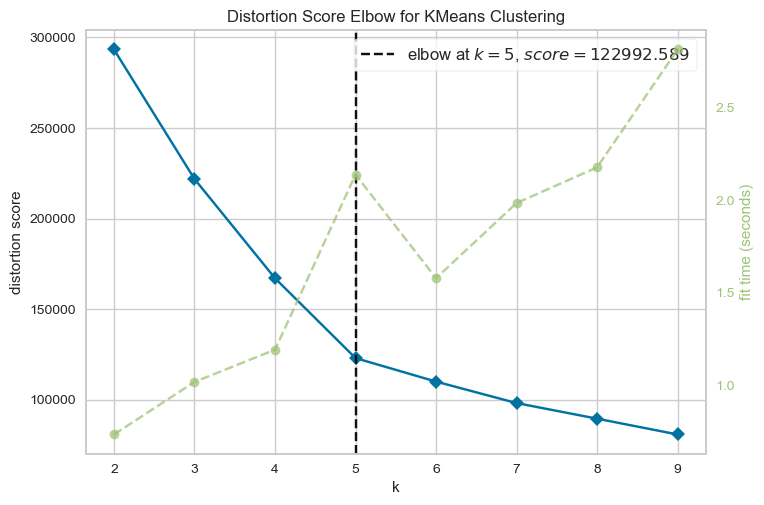

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Sélection des variables pour la modélisation
data = scaled_df[['recence', 'frequence', 'montant_total', 'score_review_minimum']]

# Création de l'estimateur KMeans
kmeans = KMeans()

# Création de l'objet de visualisation de la méthode du coude
visualizer = KElbowVisualizer(kmeans, k=(2,10))

# Adapter les données au visualiseur
visualizer.fit(data)

# Afficher la visualisation
visualizer.show()

## Détermination du nombre optimal de clusters avec les scores de silhouette

Après avoir identifié un nombre optimal de clusters préliminaire avec la méthode du coude, nous allons maintenant affiner cette décision en utilisant les scores de silhouette. Cette méthode évalue à quel point chaque point dans un cluster est proche des points dans son cluster et éloigné des points des autres clusters. Des scores plus élevés indiquent des clusters plus distincts et bien séparés.

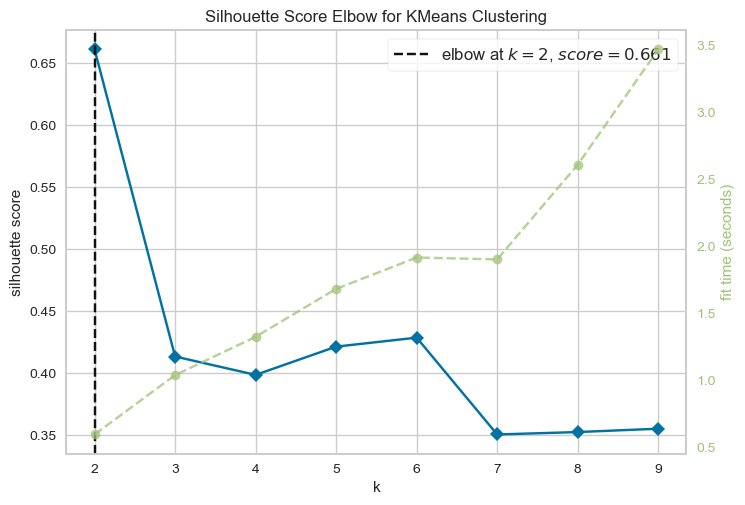

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [10]:
# Création de l'objet de visualisation de la méthode du coude avec les scores de silhouette
visualizer_silhouette = KElbowVisualizer(kmeans, k=(2,10), metric='silhouette')

# Adapter les données au visualiseur
visualizer_silhouette.fit(data)

# Afficher la visualisation
visualizer_silhouette.show()

>**Interprétation dans le Contexte Métier :** Il faut considérer le contexte métier lors de la sélection du nombre de clusters. Même si le score de silhouette pour k = 2 est le plus élevé, il pourrait être trop simpliste pour capturer la complexité et la variabilité des comportements des clients dans un contexte e-commerce. Des clusters supplémentaires peuvent aider à distinguer des nuances plus fines dans les données qui pourraient être pertinentes pour Olist.

>**Temps d'Exécution :** Le temps d'exécution, qui augmente avec le nombre de clusters, n'est pas une contrainte importante dans ce cas, comme le montre l'échelle sur l'axe des y à droite.

## Évaluation Quantitative et Application du Modèle de Clustering

L'objectif de cette étape est double : évaluer quantitativement la qualité des clusters avec différentes valeurs de k pour identifier le nombre optimal de clusters, puis appliquer le modèle KMeans avec ce nombre de clusters pour segmenter notre base de clients.

**Évaluation Quantitative de la Qualité des Clusters**

Nous allons calculer les inerties et les scores de silhouette pour une gamme de valeurs de k pour évaluer quantitativement la qualité des clusters formés.

Les inerties nous donnent une idée de la densité des clusters formés (plus l'inertie est basse, mieux c'est), tandis que les scores de silhouette nous indiquent à quel point les clusters sont bien séparés (plus le score est élevé, mieux c'est).

In [11]:
# Liste pour stocker les inerties et les scores de silhouette
inertia_scores = []
silhouette_scores = []

# Nombre de clusters à tester
k_values = range(2, 10)

# Pour chaque nombre de clusters
for k in k_values:
    # Initialisation et entraînement du modèle KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    
    # Calcul de l'inertie et stockage dans la liste
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)
    
    # Calcul du score de silhouette et stockage dans la liste
    silhouette_value = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_value)
    
    # Affichage des résultats
    print(f"Nombre de clusters : {k}, Inertie : {inertia}, Score de silhouette : {silhouette_value}")

# Affichage des listes des inerties et des scores de silhouette
print("Inerties :", inertia_scores)
print("Scores de silhouette :", silhouette_scores)

Nombre de clusters : 2, Inertie : 293269.055532999, Score de silhouette : 0.6610673281938928
Nombre de clusters : 3, Inertie : 228435.31279917771, Score de silhouette : 0.32103485505442564
Nombre de clusters : 4, Inertie : 167051.08350697777, Score de silhouette : 0.3985229432442456
Nombre de clusters : 5, Inertie : 122992.61857073137, Score de silhouette : 0.42133394100335736
Nombre de clusters : 6, Inertie : 110020.51069299283, Score de silhouette : 0.4282483911097663
Nombre de clusters : 7, Inertie : 98176.89265618174, Score de silhouette : 0.35042419000851355
Nombre de clusters : 8, Inertie : 89434.46903146777, Score de silhouette : 0.351673261198807
Nombre de clusters : 9, Inertie : 80187.01058043566, Score de silhouette : 0.35451757869199146
Inerties : [293269.055532999, 228435.31279917771, 167051.08350697777, 122992.61857073137, 110020.51069299283, 98176.89265618174, 89434.46903146777, 80187.01058043566]
Scores de silhouette : [0.6610673281938928, 0.32103485505442564, 0.39852294

**Application du KMeans avec le Nombre Optimal de Clusters**

Suite à notre évaluation quantitative, nous avons déterminé que le nombre optimal de clusters pour notre modèle est de 5. Nous allons maintenant appliquer le modèle KMeans avec ce nombre de clusters pour segmenter nos clients.

In [12]:
# Création de l'objet KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Adapter les données au modèle KMeans
kmeans.fit(data)

# Assigner chaque client à un cluster
customer_file['cluster'] = kmeans.labels_
scaled_df['cluster'] = kmeans.labels_

**Visualisation des Segments de Clients**

Enfin, nous examinons les premiers clients de chaque segment pour avoir un aperçu des groupes formés.

In [13]:
customer_file.head()

,customer_unique_id,recence,frequence,montant_total,score_review_minimum,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,153.132905,1,129.90,5,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159.248125,1,18.90,4,4
2,0000f46a3911fa3c0805444483337064,559.389734,1,69.00,3,1
3,0000f6ccb0745a6a4b88665a16c9f078,349.108970,1,25.99,4,1
4,0004aac84e0df4da2b147fca70cf8255,323.035463,1,180.00,5,1


In [14]:
scaled_df.head()

,recence,frequence,montant_total,score_review_minimum,cluster
0,-0.789847,-0.160071,-0.053605,0.663454,4
1,-0.749598,-0.160071,-0.571158,-0.109947,4
2,1.884037,-0.160071,-0.337560,-0.883349,1
3,0.500020,-0.160071,-0.538100,-0.109947,1
4,0.328411,-0.160071,0.179993,0.663454,1


# Étape 5: Analyse et visualisation des Clusters <a class="anchor" id="Analyse-et-Visualisation-des-Clusters"></a>


Cette étape est dédiée à une analyse plus fine des clusters identifiés grâce au modèle de KMeans. Nous allons examiner les statistiques descriptives de chaque cluster et visualiser leurs caractéristiques pour mieux comprendre leur composition et comportement.

## Statistiques descriptives par cluster

Nous commençons par examiner les statistiques descriptives pour chaque variable, segmentées par cluster. Cela nous donne une vue d'ensemble de la distribution des variables au sein de chaque segment.

[Retour au sommaire](#sommaire)

In [15]:
# Affichage de la variable 'recence'
print("Tableau de la variable 'recence'")
display(customer_file[['recence']].groupby(customer_file['cluster']).describe())

# Affichage de la variable 'frequence'
print("Tableau de la variable 'frequence'")
display(customer_file[['frequence']].groupby(customer_file['cluster']).describe())

# Affichage de la variable 'montant_total'
print("Tableau de la variable 'montant_total'")
display(customer_file[['montant_total']].groupby(customer_file['cluster']).describe())

# Affichage de la variable 'score_review_minimum'
print("Tableau de la variable 'score_review_minimum'")
display(customer_file[['score_review_minimum']].groupby(customer_file['cluster']).describe())


Tableau de la variable 'recence'


recence                                                              \
           count        mean         std         min         25%         50%   
cluster                                                                        
0        15794.0  256.881056  125.620958   19.899618  171.373637  235.322755   
1        30496.0  433.796011   93.785208  296.296030  354.156383  425.171817   
2         2764.0  254.989617  142.744649   33.109410  137.234954  231.135116   
3         1999.0  271.294797  151.047021   34.155810  147.278628  250.125729   
4        41694.0  163.079408   73.364614   -0.557477   98.253018  161.156395   

                                 
                75%         max  
cluster                          
0        319.403715  733.344132  
1        505.511913  735.426019  
2        355.051881  720.459433  
3        385.061337  729.497836  
4        225.080518  299.558750

Tableau de la variable 'frequence'


frequence                                              
            count      mean       std  min  25%  50%  75%   max
cluster                                                        
0         15794.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
1         30496.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
2          2764.0  2.114689  0.505720  2.0  2.0  2.0  2.0  15.0
3          1999.0  1.015008  0.133389  1.0  1.0  1.0  1.0   4.0
4         41694.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0

Tableau de la variable 'montant_total'


montant_total                                                      \
                count         mean         std     min       25%      50%   
cluster                                                                     
0             15794.0   125.744354  116.608896    3.54   49.0000   89.900   
1             30496.0   112.822537  105.526532    2.29   44.9900   79.900   
2              2764.0   242.373965  207.789828   11.98  112.8725  179.935   
3              1999.0  1179.118054  677.857234  639.92  797.7000  970.000   
4             41694.0   111.778801  101.352617    0.85   44.9000   82.000   

                            
             75%       max  
cluster                     
0         159.00    759.00  
1         139.99    739.98  
2         299.80   2200.00  
3        1340.00  13440.00  
4         142.00    682.98

Tableau de la variable 'score_review_minimum'


score_review_minimum                                             
                       count      mean       std  min  25%  50%  75%  max
cluster                                                                  
0                    15794.0  1.742307  0.874264  1.0  1.0  1.0  3.0  3.0
1                    30496.0  4.634805  0.596811  2.0  4.0  5.0  5.0  5.0
2                     2764.0  3.834660  1.450528  1.0  3.0  4.0  5.0  5.0
3                     1999.0  4.106053  1.353362  1.0  4.0  5.0  5.0  5.0
4                    41694.0  4.713028  0.500291  3.0  4.0  5.0  5.0  5.0

## Visualisation des Variables pour Chaque Cluster

Pour mieux comprendre comment chaque cluster varie en fonction des différentes variables, nous utilisons des diagrammes en boîte.

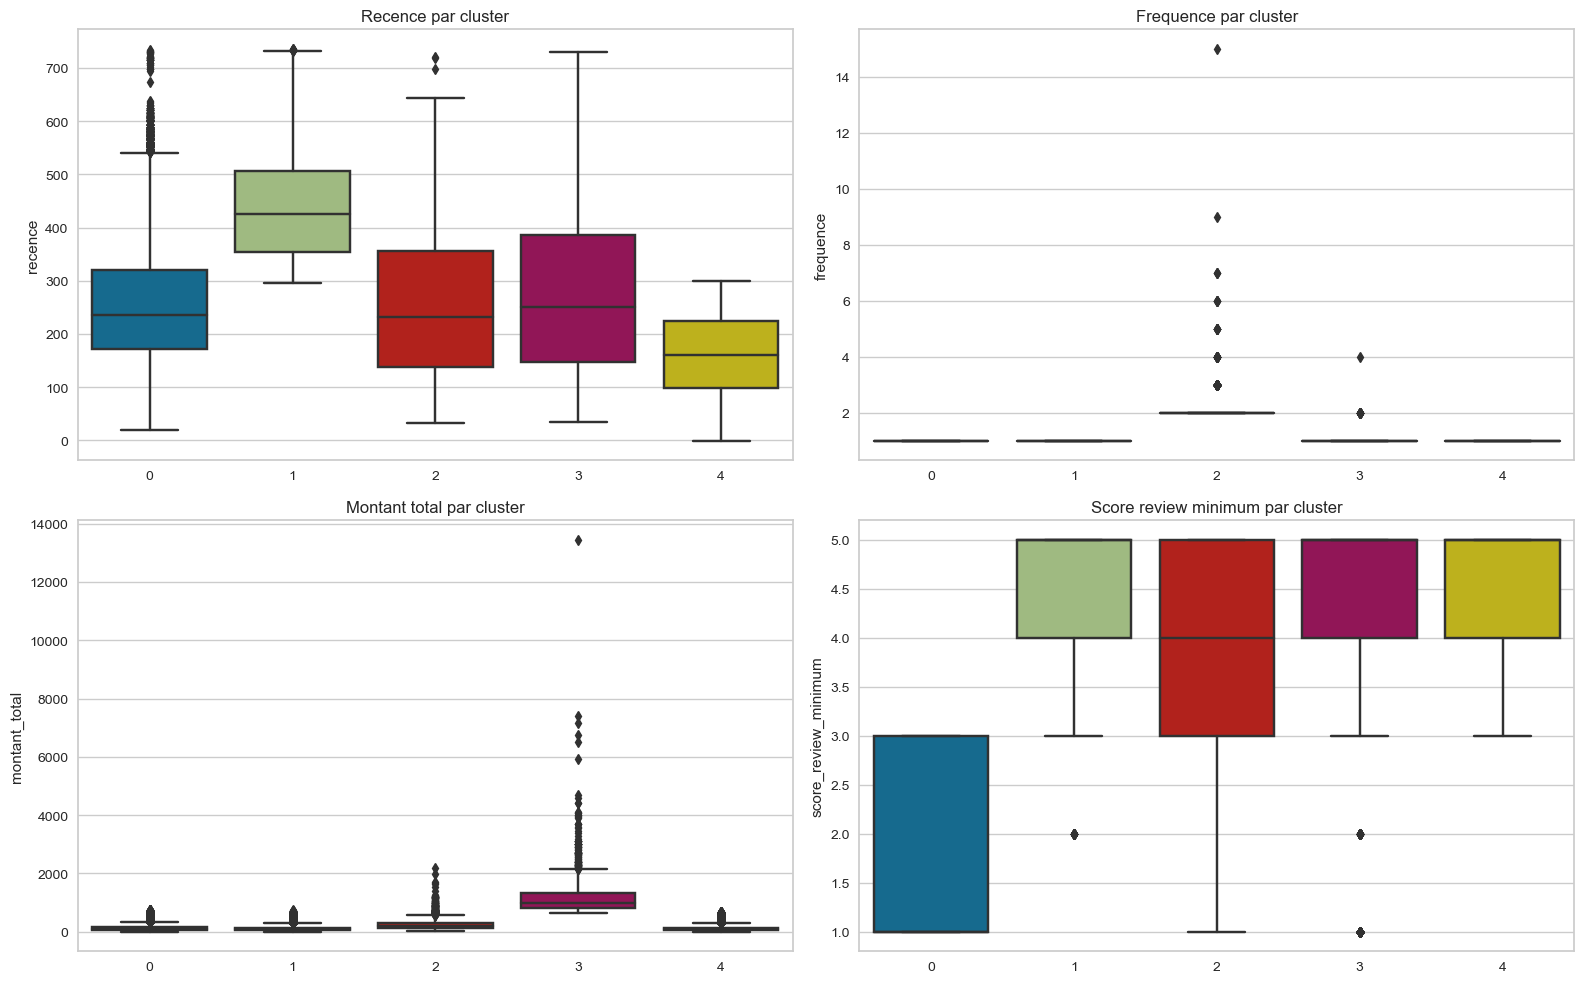

In [16]:
# Visualisation des variables pour chaque cluster
plt.figure(figsize=(16, 10))

# Diagramme en boîte pour la variable 'recence'
plt.subplot(2, 2, 1)
sns.boxplot(x=kmeans.labels_, y=customer_file['recence'])
plt.title("Recence par cluster")

# Diagramme en boîte pour la variable 'frequence'
plt.subplot(2, 2, 2)
sns.boxplot(x=kmeans.labels_, y=customer_file['frequence'])
plt.title("Frequence par cluster")

# Diagramme en boîte pour la variable 'montant_total'
plt.subplot(2, 2, 3)
sns.boxplot(x=kmeans.labels_, y=customer_file['montant_total'])
plt.title("Montant total par cluster")

# Diagramme en boîte pour la variable 'score_review_minimum'
plt.subplot(2, 2, 4)
sns.boxplot(x=kmeans.labels_, y=customer_file['score_review_minimum'])
plt.title("Score review minimum par cluster")

plt.tight_layout()
plt.show()

>**Recence par Cluster**

>* Les boîtes à moustaches pour la recence montrent que les clusters ont des médianes assez différentes, ce qui indique une bonne séparation temporelle entre les clusters.
>* Le Cluster O semble contenir des clients avec une recence plus faible, suggérant que ce sont des clients qui ont fait des achats plus récemment.
>* Les Clusters 1 et 4 présentent des recences plus élevées, indiquant des clients qui ont fait leurs achats il y a plus longtemps.
>* Les différences dans les étendues et les valeurs extrêmes (les points au-delà des "moustaches") indiquent également une variabilité dans la fréquence des interactions des clients avec Olist.


>**Frequence par Cluster**

>* Pour la frequence, les clusters semblent avoir des médianes similaires, la plupart proches de 1, ce qui pourrait indiquer que la majorité des clients n'ont acheté qu'une ou très peu de fois, quelle que soit leur segmentation.
>* Les valeurs aberrantes pour les clusters montrent qu'il y a des clients qui ont une fréquence d'achat nettement plus élevée que la majorité.


>**Montant Total par Cluster**

>* Concernant le montant total, les clusters montrent une grande variété de dépenses. Par exemple, le Cluster 3 présente un montant total significativement plus élevé que les autres, indiquant que ce cluster pourrait être composé de clients à haute valeur.
>* Les valeurs extrêmes du Cluster 3 sont particulièrement intéressantes car elles pourraient représenter des clients qui ont fait des achats exceptionnellement élevés, potentiellement des acheteurs en gros ou des achats d'articles de luxe.


>**Score Review Minimum par Cluster**

>* Les scores de review minimums sont distribués assez uniformément entre les clusters, avec des médianes généralement élevées, ce qui indique un niveau de satisfaction globalement positif dans tous les segments.
>* Cependant, la présence de scores faibles, comme indiqué par les valeurs minimales et les valeurs aberrantes dans certains clusters, pourrait signaler des problèmes de satisfaction client dans des cas spécifiques.

## Évaluation de la Qualité du Clustering

Pour assurer la robustesse de notre segmentation, nous examinons les métriques de qualité des clusters.

In [17]:
# Calcul et affichage des métriques de qualité des clusters
davies_bouldin = davies_bouldin_score(data, kmeans.labels_)
silhouette = silhouette_score(data, kmeans.labels_)
print(f"Score Davies-Bouldin : {davies_bouldin}")
print(f"Coefficient de silhouette : {silhouette}")

Score Davies-Bouldin : 0.7738038752669968
Coefficient de silhouette : 0.42133394100335736


**Score Davies-Bouldin (0.774)**
Un score de 0.774 est relativement bas, ce qui suggère que les clusters ne sont pas trop mal définis. Toutefois, il y a toujours de la marge pour améliorer la séparation entre les clusters et réduire la dispersion à l'intérieur des clusters.

**Coefficient de Silhouette (0.421)**
Un score de 0.421 indique une séparation acceptable entre les clusters, mais il y a clairement de la place pour des améliorations. Les clusters ne se chevauchent pas de manière significative, mais les points ne sont pas non plus extrêmement bien séparés.

## Analyse des Moyennes des Caractéristiques par Cluster

Pour une analyse détaillée, nous calculons les moyennes des caractéristiques pour chaque cluster.

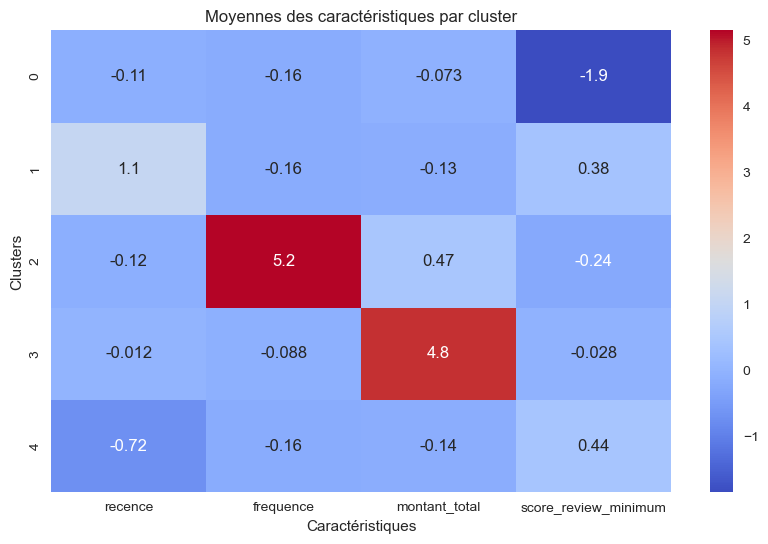

In [18]:
# Calcul et visualisation des moyennes par cluster
cluster_means = scaled_df.groupby('cluster').mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Moyennes des caractéristiques par cluster')
plt.xlabel('Caractéristiques')
plt.ylabel('Clusters')
plt.show()

>**Analyse des Clusters**
>* **Cluster 0** semble avoir une recence légèrement inférieure à la moyenne, une frequence et un montant total moyens assez bas, et un score review minimum très bas, indiquant des clients récents mais peu fréquents et moins satisfaits.


>* **Cluster 1** montre une recence très élevée, ce qui suggère des clients ayant effectué des achats il y a longtemps, une frequence moyenne basse, un montant total légèrement inférieur à la moyenne, mais avec un score review minimum relativement élevé.


>* **Cluster 2** se distingue par une frequence d'achat extrêmement élevée et un montant total plus élevé que la moyenne, ce qui peut représenter des clients très actifs qui font souvent des achats importants. Cependant, leur score review minimum est légèrement inférieur à la moyenne.


>* **Cluster 3** présente un montant total très élevé, suggérant que ces clients dépensent beaucoup lorsqu'ils achètent, bien que leur frequence d'achat soit légèrement inférieure à la moyenne.


>* **Cluster 4** semble regrouper des clients avec la recence la plus faible, indiquant des interactions très récentes avec la plateforme, mais avec des valeurs moyennes faibles pour la frequence, le montant total et un score review minimum légèrement supérieur à la moyenne.

## Visualisation Radar des Clusters

Les graphiques radars offrent une visualisation distinctive des profils des clusters sur plusieurs variables.

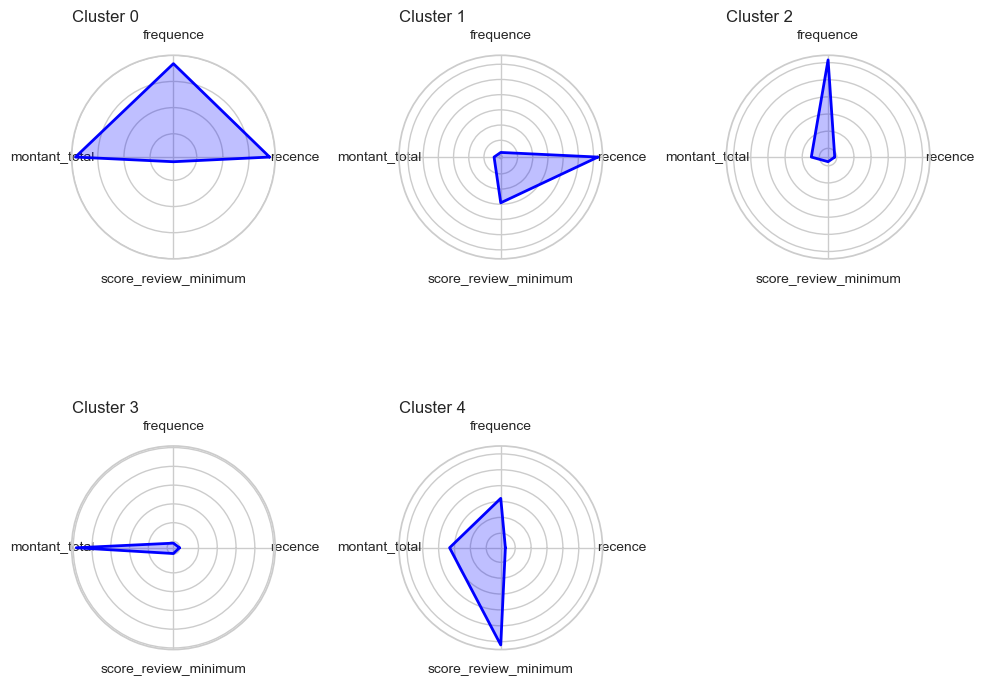

In [19]:
# Définir les caractéristiques à inclure dans le graphique radar
features = cluster_means.columns.tolist()

# Nombre de caractéristiques
num_features = len(features)

# Nombre de clusters
num_clusters = len(cluster_means)

# Définir la disposition de subplot
num_rows = num_clusters // 2
num_cols = num_clusters // num_rows
if num_clusters % 2 != 0:
    num_cols += 1

# Créer un graphique radar pour chaque cluster
plt.figure(figsize=(10, 8))

for cluster_id in range(num_clusters):
    values = cluster_means.iloc[cluster_id].values
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    values = np.concatenate((values,[values[0]]))
    angles += angles[:1]
    
    ax = plt.subplot(num_rows, num_cols, cluster_id + 1, polar=True)
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title(f'Cluster {cluster_id}', loc='left')

plt.tight_layout()
plt.show()


>**Cluster 0**
>* Il montre des valeurs supérieures à la moyenne pour la frequence, ce qui suggère que les clients de ce cluster achètent plus fréquemment que ceux des autres clusters.
>* Les autres caractéristiques (montant_total, recence, score_review_minimum) sont proches de la moyenne ou inférieures, indiquant que ces clients pourraient être réguliers mais dépensent moins par achat ou ont des scores de satisfaction variés.


>**Cluster 1**
>* Ce cluster se distingue principalement par la recence avec des valeurs bien supérieures à la moyenne, indiquant des achats récents.
>* Les autres caractéristiques sont autour de la moyenne ou en dessous, ce qui pourrait suggérer des clients récents avec un comportement d'achat modéré et une satisfaction diverse.


>**Cluster 2**
>* Il est caractérisé par des scores extrêmement élevés en frequence, ce qui implique une activité d'achat très fréquente par rapport aux autres clusters.
>* Cependant, ce cluster semble avoir des valeurs moyennes pour montant_total et score_review_minimum, et une recence proche de la moyenne.


>**Cluster 3**
>* Ce cluster se distingue par de très hautes valeurs en montant_total, ce qui indique que ces clients dépensent beaucoup plus que la moyenne lorsqu'ils effectuent des achats.
>* Le reste des caractéristiques tend vers la moyenne, ce qui pourrait signaler des clients qui font des achats importants mais moins fréquents.


>**Cluster 4**
>* Les clients de ce cluster ont des scores élevés pour score_review_minimum, indiquant une satisfaction générale élevée par rapport aux autres clusters.
>* Pour recence, frequence et montant_total, ce cluster présente des valeurs proches de la moyenne ou inférieures.

## Visualisation des Clusters en 2D avec ACP

L'Analyse en Composantes Principales (ACP) nous permet de visualiser les clusters en deux dimensions, facilitant l'appréhension des séparations entre eux.

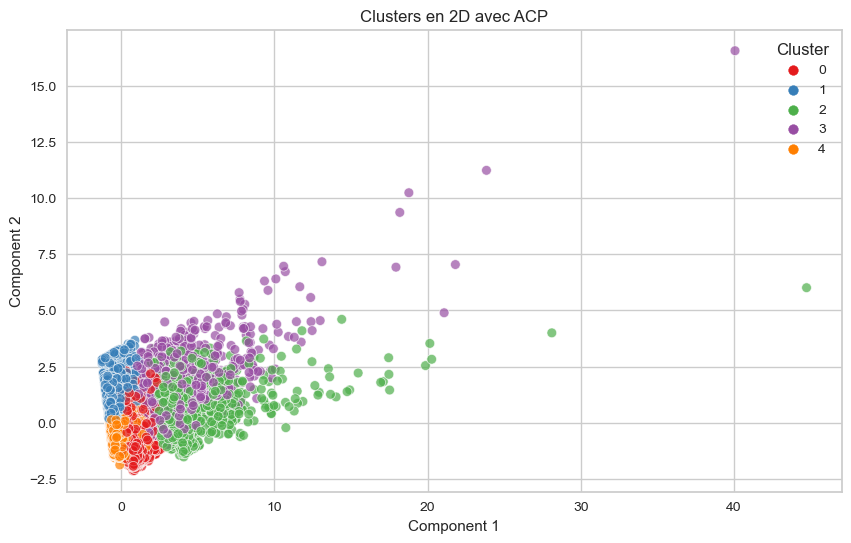

In [20]:
# Sélection des colonnes à inclure dans l'ACP (excluant la colonne 'Cluster')
columns_to_include = ['recence', 'frequence', 'montant_total', 'score_review_minimum']

# Sélection des données pour l'ACP (en excluant la colonne 'Cluster')
data_for_pca = scaled_df[columns_to_include]

# Réduction de la dimensionnalité avec l'ACP
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_for_pca)

# Création du DataFrame pour les données réduites en dimension
pca_df = pd.DataFrame(pca_result, columns=['Component 1', 'Component 2'])

# Ajout de la colonne des clusters au DataFrame réduit en dimension
pca_df['Cluster'] = kmeans.labels_

# Visualisation des clusters en 2D avec l'ACP
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Component 1', y='Component 2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('Clusters en 2D avec ACP')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.show()


>**Observations Générales :**

>* **Répartition des Clusters :** On observe une répartition des clusters le long du premier composant principal (Component 1), ce qui suggère que cette dimension capte une variance significative entre les clients. Le deuxième composant principal (Component 2) contribue également à la séparation, bien que dans une moindre mesure.


>* **Séparation des Clusters :** Les clusters semblent être relativement bien définis, surtout pour les Clusters 0, 1 et 2, qui montrent des groupes compacts dans l'espace réduit. Cela indique une bonne séparation au sein de l'espace des caractéristiques choisies.


>* **Chevauchement des Clusters :** Il y a un certain chevauchement entre les Clusters 2 et 3, ce qui pourrait indiquer des similitudes entre les comportements ou caractéristiques des clients de ces deux clusters. Cela pourrait nécessiter une analyse plus approfondie pour comprendre les nuances subtiles entre eux.


>* **Distinction du Cluster 4 :** Le Cluster 4 se distingue des autres, notamment en termes de Component 2, indiquant que les clients de ce cluster ont des caractéristiques uniques qui les distinguent dans l'espace de caractéristiques réduit.

In [21]:
# Coefficients de chargement pour chaque composante
loading_scores = pd.DataFrame(pca.components_, columns=data_for_pca.columns)

# Affichage des coefficients de chargement
print("Coefficients de chargement pour chaque composante :")
print(loading_scores)

Coefficients de chargement pour chaque composante :
    recence  frequence  montant_total  score_review_minimum
0 -0.171736   0.645859       0.634192             -0.388810
1  0.942274   0.098210       0.265128              0.179391


## Description des Clusters

**Cluster 0 - "Les Nouveaux Prometteurs"**
Ces clients ont récemment commencé à interagir avec Olist. Ils sont caractérisés par une fréquence d'achat moyenne, des dépenses modestes et une satisfaction à développer. Les efforts de marketing pourraient se concentrer sur l'amélioration de leur expérience pour les fidéliser.


**Cluster 1 - "Les Clients Ponctuels"**
Ce groupe inclut des clients avec une certaine ancienneté mais des achats occasionnels. Ils sont généralement satisfaits de leurs expériences mais n'engagent pas de dépenses significatives. Ils pourraient bénéficier de stratégies de réengagement personnalisées.


**Cluster 2 - "Les Acheteurs Enthousiastes"**
Leur fréquence d'achat très élevée les distingue comme des clients actifs. Bien que leurs dépenses ne soient pas les plus hautes, leur engagement régulier suggère un potentiel de croissance par le biais de programmes de fidélisation ou d'offres ciblées.


**Cluster 3 - "Les Clients Prestige"**
Représentant les clients qui investissent le plus dans leurs achats, ce cluster regroupe des consommateurs faisant de gros achats, bien que moins fréquents. Des offres exclusives et des programmes VIP pourraient les intéresser et augmenter leur valeur à long terme.


**Cluster 4 - "Les Ambassadeurs Satisfaits"**
Ce cluster se caractérise par une satisfaction client élevée et des interactions récentes, malgré une fréquence d'achat et des dépenses modestes. Ce sont des candidats idéaux pour des campagnes de co-création ou de témoignages qui capitalisent sur leur satisfaction.

## Étape 6 : Comparaison des Méthodes de Clustering <a class="anchor" id="Comparaison-des-Méthodes-de-Clustering"></a>


Après avoir identifié les segments de clients à l'aide de l'algorithme KMeans, il est pertinent de comparer d'autres méthodes de clustering pour voir si elles peuvent offrir des perspectives différentes ou améliorer notre compréhension des groupes de clients.

[Retour au sommaire](#sommaire)

### Test du CAH (Clustering Hiérarchique Agglomératif)

Le CAH est une approche alternative qui construit une hiérarchie de clusters et peut être utile pour comprendre la structure des données à différents niveaux de granularité.

**Application de KMeans (Approche Grossière)**

Nous commençons par une application simplifiée de KMeans pour établir une base de comparaison.

In [22]:
# Sélection des caractéristiques pour le clustering
features = scaled_df[['recence', 'frequence', 'montant_total', 'score_review_minimum']]

# Application du KMeans avec 5 clusters
kmeans_grossier = KMeans(n_clusters=5, random_state=42)
kmeans_grossier.fit(features)

# Extraction des centres des clusters
centers = kmeans_grossier.cluster_centers_

# Affiche centres des clusters
print("Centres des clusters :", centers)

Centres des clusters : [[-0.10681786 -0.16007062 -0.07298582 -1.85623435]
 [ 1.0574098  -0.16007062 -0.13323121  0.38101114]
 [-0.11945075  5.15936     0.47081973 -0.23782163]
 [-0.012134   -0.08845299  4.83851487 -0.02792589]
 [-0.72440681 -0.16007062 -0.13809144  0.4414141 ]]


>**Cluster 0**
Ce cluster a des valeurs relativement proches de zéro pour recence, frequence et montant_total, mais une valeur très négative pour score_review_minimum. Cela suggère que ce sont des clients récents qui n'achètent pas fréquemment ou qui ne dépensent pas beaucoup, mais dont la satisfaction est significativement basse par rapport à la moyenne. Ce cluster pourrait représenter des clients qui ont eu une mauvaise première expérience ou dont les attentes n'ont pas été satisfaites.

>**Cluster 1**
Les clients de ce cluster ont une recence élevée, indiquant qu'ils n'ont pas effectué d'achats récemment. Leur frequence et montant_total sont inférieurs à la moyenne, mais leur score_review_minimum est positif, ce qui indique une satisfaction passable. Cela peut représenter des clients occasionnels qui n'ont pas de griefs majeurs mais qui ne sont pas non plus fortement engagés avec Olist.

>**Cluster 2**
Ce cluster se distingue par une très haute frequence d'achats, ainsi qu'un montant_total légèrement supérieur à la moyenne, ce qui suggère des clients très actifs qui font des achats fréquents et dépensent bien. Le score_review_minimum légèrement en dessous de la moyenne pourrait indiquer que bien que ces clients achètent souvent, il y a une marge d'amélioration dans leur satisfaction.

>**Cluster 3**
Avec un montant_total extrêmement élevé, ce cluster semble regrouper des clients qui font des achats majeurs, peut-être moins fréquemment (comme indiqué par une frequence légèrement inférieure à la moyenne), mais quand ils le font, ils dépensent beaucoup. Le score_review_minimum proche de la moyenne indique une satisfaction neutre.

>**Cluster 4**
Ce cluster présente une recence faible, ce qui signifie que les clients ici ont effectué leurs derniers achats plus récemment que ceux du Cluster 1. La frequence et le montant_total sont bas, mais le score_review_minimum est positif, ce qui suggère que ce groupe de clients pourrait être constitué de nouveaux clients satisfaits ou de clients qui achètent sporadiquement mais qui sont généralement contents de leurs interactions avec Olist.

### Visualisation des Clusters via un Dendrogramme

La visualisation hiérarchique nous aide à voir comment les clusters KMeans sont liés entre eux et à quel niveau ils fusionnent.

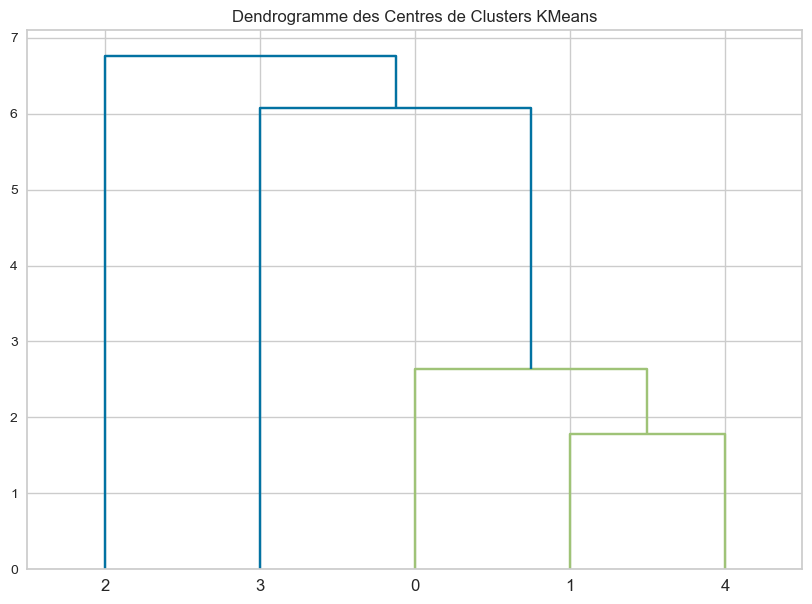

In [23]:
# Utilisation de la méthode 'linkage' pour calculer les distances entre les centres de clusters
Z = linkage(centers, 'ward')

# Création et affichage du dendrogramme
plt.figure(figsize=(10, 7))
plt.title('Dendrogramme des Centres de Clusters KMeans')
dendrogram(Z)
plt.show()

> **Analyse du Dendrogramme :**
>* **Clusters 0 et 1 :** Ils sont les premiers à être reliés à un niveau de dissimilarité relativement faible, ce qui suggère qu'ils sont les plus similaires en termes de caractéristiques des clients. Cette proximité peut indiquer que bien que distincts, les clients de ces deux clusters peuvent partager des caractéristiques communes.


>* **Cluster 4 :** Ce cluster est le suivant à se joindre au groupe formé par les Clusters 0 et 1, à un niveau légèrement plus élevé de dissimilarité. Cela peut indiquer que le Cluster 4 partage certaines similitudes avec les Clusters 0 et 1, mais possède également des caractéristiques uniques qui le distinguent.


>* **Clusters 2 et 3 :** Ils forment leur propre groupe séparément des trois autres clusters, indiquant qu'ils sont distincts non seulement des uns des autres mais aussi du groupe précédent. Cela peut refléter une différence significative dans le comportement ou les caractéristiques de leurs clients respectifs.


>* **Fusion Finale :** Finalement, les deux groupes se rejoignent à un niveau de dissimilarité plus élevé, ce qui montre que, dans l'ensemble, il existe une séparation claire entre les deux ensembles de clusters.

### Conclusion

<span style="color:crimson">Dans le contexte de la segmentation des clients d'Olist, voici pourquoi le CAH pourrait être moins utile par rapport au KMeans :</span>.

**Complexité Computationnelle**
Le CAH a une complexité temporelle qui peut être prohibitivement élevée pour les grands ensembles de données, comme c'est souvent le cas dans le commerce en ligne. KMeans est généralement plus rapide et donc plus adapté à la manipulation de grands volumes de données.

**Difficulté d'Interprétation à Grande Échelle**
Alors que le CAH peut fournir des insights détaillés sur la structure des données, le dendrogramme résultant peut devenir encombré et difficile à interpréter avec un grand nombre de points, ce qui est le cas avec les données client d'une plateforme e-commerce.

**Manque de Flexibilité pour l'Affectation des Clusters**
Une fois que les clusters sont formés dans le CAH, il n'est pas possible de réassigner les points à d'autres clusters sans reconstruire tout l'arbre hiérarchique, tandis que KMeans offre une plus grande flexibilité en permettant des réaffectations à chaque itération.

**Application Pratique et Scalabilité**
Enfin, KMeans est bien établi et largement utilisé dans les applications de segmentation client en raison de sa simplicité, de son efficacité et de la facilité avec laquelle il peut être mis à l'échelle et automatisé, ce qui est crucial pour une entreprise en ligne en expansion comme Olist.

Pour toutes ces raisons, bien que le CAH puisse être précieux pour obtenir des perspectives initiales sur la structure des données ou pour des ensembles de données plus petits, le KMeans s'avère être une méthode plus pratique et utile pour la segmentation des clients dans notre cas.

## Test du DBSCAN

Le DBSCAN est une autre méthode de clustering basée sur la densité, qui peut capturer des formes de clusters complexes et identifier des bruits.

In [24]:
# Implémentation du DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(customer_file[['recence', 'frequence', 'montant_total', 'score_review_minimum']])
dbscan_silhouette_score = silhouette_score(customer_file[['recence', 'frequence', 'montant_total', 'score_review_minimum']], dbscan_clusters)

print("Clusters DBSCAN :", dbscan_clusters)
print("Score de silhouette DBSCAN :", dbscan_silhouette_score)

Clusters DBSCAN : [-1 -1 -1 ... -1 -1 -1]
Score de silhouette DBSCAN : -0.7508290222028584


>**Clusters DBSCAN :** [-1 -1 -1 ... -1 -1 -1] : Tous les points de données ont été étiquetés avec l'indice de cluster -1, ce qui signifie que DBSCAN les a tous considérés comme du bruit plutôt que comme faisant partie d'un cluster. Cela peut arriver lorsque les données ne sont pas bien adaptées aux hypothèses du DBSCAN ou lorsque les paramètres eps et min_samples ne sont pas correctement choisis.

>**Score de silhouette DBSCAN :** -0.7508290222028584 : Un score de silhouette négatif indique que les points de données sont mal classés, avec une très faible cohésion de cluster et une faible séparation entre les clusters. En fait, étant donné que tous les points sont marqués comme du bruit, ce score négatif extrême n'est pas surprenant.

### Ajustement des Paramètres du DBSCAN

Les paramètres eps et min_samples de DBSCAN sont critiques et peuvent grandement influencer les résultats.

In [25]:
# Variations des paramètres eps et min_samples
eps_values = [0.5, 1.0, 1.5]  # Liste des valeurs d'eps à tester
min_samples_values = [5, 10, 15]  # Liste des valeurs de min_samples à tester

# Expérimentation avec différents paramètres pour optimiser DBSCAN
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_clusters = dbscan.fit_predict(customer_file[['recence', 'frequence', 'montant_total', 'score_review_minimum']])
        dbscan_silhouette_score = silhouette_score(customer_file[['recence', 'frequence', 'montant_total', 'score_review_minimum']], dbscan_clusters)

        # Affichage des résultats pour chaque configuration
        print(f"DBSCAN eps={eps}, min_samples={min_samples}, clusters : {dbscan_clusters}")
        print(f"DBSCAN eps={eps}, min_samples={min_samples}, silhouette : {dbscan_silhouette_score}")


DBSCAN eps=0.5, min_samples=5, clusters : [-1 -1 -1 ... -1 -1 -1]
DBSCAN eps=0.5, min_samples=5, silhouette : -0.7508290222028584
DBSCAN eps=0.5, min_samples=10, clusters : [-1 -1 -1 ... -1 -1 -1]
DBSCAN eps=0.5, min_samples=10, silhouette : -0.7350282050280227
DBSCAN eps=0.5, min_samples=15, clusters : [-1 -1 -1 ... -1 -1 -1]
DBSCAN eps=0.5, min_samples=15, silhouette : -0.07575565177913743
DBSCAN eps=1.0, min_samples=5, clusters : [ 0 -1 -1 ... -1 -1 -1]
DBSCAN eps=1.0, min_samples=5, silhouette : -0.5053894146315446
DBSCAN eps=1.0, min_samples=10, clusters : [-1 -1 -1 ... -1 -1 -1]
DBSCAN eps=1.0, min_samples=10, silhouette : -0.7131242701808108
DBSCAN eps=1.0, min_samples=15, clusters : [-1 -1 -1 ... -1 -1 -1]
DBSCAN eps=1.0, min_samples=15, silhouette : -0.7402917681676412
DBSCAN eps=1.5, min_samples=5, clusters : [   0    1  576 ...  197  822 1461]
DBSCAN eps=1.5, min_samples=5, silhouette : -0.18403258218122098
DBSCAN eps=1.5, min_samples=10, clusters : [  0   1  -1 ...  -1 973 

**Analyse des résultats du DBSCAN :**

Le DBSCAN semble ne pas fonctionner efficacement sur ce jeu de données. Cela est indiqué par le fait que tous les points sont assignés au (label -1) avec les paramètres initiaux (eps=0.5 et min_samples=5), et ce résultat persiste même après ajustement des paramètres. Les scores de silhouette négatifs ou très bas suggèrent une mauvaise séparation des clusters. Cela peut être dû à plusieurs raisons :

1. La densité des données varie trop fortement, ce qui rend difficile pour DBSCAN de trouver des clusters de densité similaire.
2. Les variables présentent des échelles différentes, et même après la normalisation, il peut y avoir des zones de densité élevée qui sont considérées comme du bruit par le DBSCAN.
3. Les clusters peuvent ne pas être bien définis ou séparables selon une densité uniforme, ce qui est une hypothèse de base du DBSCAN.

En comparaison, KMeans (même dans sa version "grossière") a réussi à identifier des clusters distincts, comme en témoignent les centres de clusters et les visualisations fournies.

Ces résultats suggèrent que, pour ce jeu de données, les méthodes basées sur la densité comme DBSCAN ne sont pas les plus appropriées, et que des méthodes basées sur la partition, comme **KMeans**, sont préférables pour identifier des structures de clusters significatives.


label(-1) values_counts

ajouter une variable qualitative -> onehotencodeur (Kmeans)